# 09. 회귀실습 - 자전거 대여 수요 예측

캐글의 자전거 대여 수요 예측 경연에서 사용된 학습 데이터 세트를 이용 (https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv)

데이터 세트의 주요 칼럼은 아래와 같으며 이중 결정 값은 맨 마지막 칼럼인 count로 '대여 횟수'를 의미한다.

+ datetime : hourly date + timestamp
+ season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
+ holiday : 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
+ workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
+ weather :
  + 1 = 맑음, 약간 구름 낀 흐림
  + 2 = 안개, 안개 + 흐림
  + 3 = 가벼운 눈, 가벼운 비 + 천둥
  + 4 = 심한 눈/비, 천둥/번개
+ temp : 온도(섭씨)
+ atemp : 체감온도(섭씨)
+ humidity : 상대습도
+ casual : 사전에 등록되지 않는 사용자가 대여한 횟수
+ registered : 사전에 등록된 사용자가 대여한 횟수
+ count : 대여 횟수

#### 데이터 클렌징 및 가공과 데이터 시각화

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


10886개의 레코드와 12개의 칼럼으로 구성돼 있다. 데이터 칼럼의 타입을 살펴본다.

In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime 칼럼만 object형이다. datime 칼럼의 경우 년-월-일 시:분:초 문자 형식으로 이루어져 있으므로 가공을 해 년, 월, 일 그리고 시간과 같이 4개의 속성으로 분리해준다.

판다스에서 문자열을 'datetime' 타입으로 변경한다. 판다스는 문자열을 datetime 타입으로 변환하는 apply(pd.to_datetime) 메서드를 제공한다. 

In [ ]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [ ]:
# 기존에 있던 datime 열은 삭제
# casual : 사전에 등록하지 안흔 사용자의 자전거 대여 횟수
# registered : 사전에 등록한 사용자의 대여 횟수
# count = casual + registered
# casual과 registered가 따로 필요하지 않을 것으로 판단, 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 두 칼럼을 삭제

drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

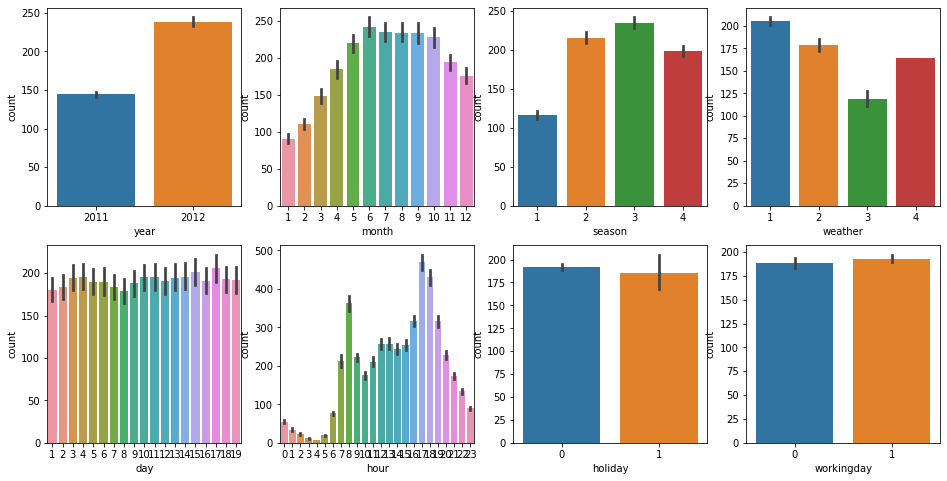

In [ ]:
# 주요 칼럼별로 Target값인 count(대여 횟수)가 어떻게 분포되어 있는지 시각화

fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

여러가지 예측 성능 평가 지표를 계산하는 함수를 정의한다.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

회귀 모델을 적용하기 전에 데이터 세트에 대해서 먼저 처리해야 할 사항

+ 1. 결과값이 정규 분포로 돼 있는지 확인
+ 2. 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩

------------------------------

#### 데이터 전처리 없이 사이킷런의 LinearRegression 객체를 이용해 회귀 예측을 했을 때

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인해 본다.

In [ ]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


-------------------------

회귀에서 이렇게 큰 오류가 발생할 경우 Target값의 분포가 왜곡된 형태를 이루고 있는지 확인

Target값의 분포는 정규 분포 형태가 가장 좋다.

<AxesSubplot:>

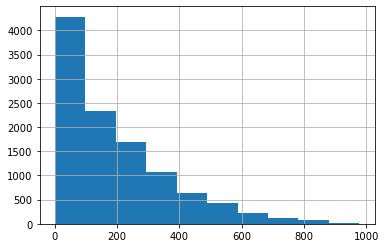

In [ ]:
y_target.hist()

왜곡된 값을 정규 분포 형태로 바꿔준다.
+ 가장 일반적으로 로그를 적용해 변환한다.

<AxesSubplot:>

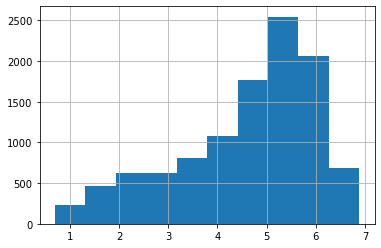

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

로그 변환된 값을 이용해 다시 학습한 후 평가를 수행한다.

In [ ]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


RMSLE 오류는 줄어 들었지만, RMSE는 오히려 더 늘어났다. 

--------------------------
이번에는 개별 피처들의 인코딩을 적용해 본다. 먼저 각 피처의 회귀 계숫값을 시각화한다.

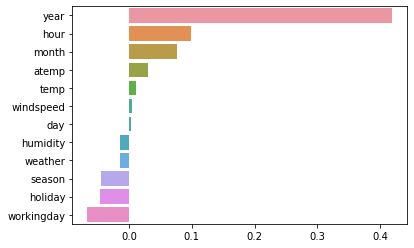

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높다. 이들은 모두 카테고리형 피처이다. 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다. 따라 선형 회귀에서는 이러한 카테고리형 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

In [ ]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

사이킷런의 선형 회귀 모델인 LinearRegression, Redgie, Lasso 모두 학습해 예측 성능을 확인한다. 이를 위해 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하는 get_model_predict() 함수를 만든다.

In [ ]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


원-핫 인코딩을 적용한 후 선형 회귀의 예측 성능이 많이 향상됐다. 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화한다. 원-핫 인코딩으로 피처가 늘어났으므로 회귀 계수 상위 20개 피처를 추출해본다.

<AxesSubplot:>

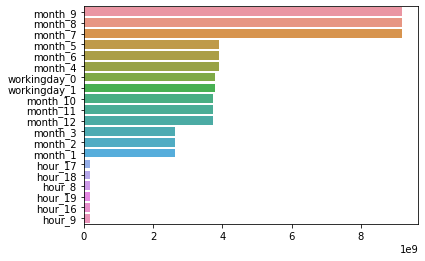

In [ ]:

coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

여전히 year 관련 피처들의 회귀 계수 값이 가장 높지만 season 관련, weather 관련 속성들의 회귀 계수 값도 상대적으로 커졌다.

-------------------

Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용해 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가해 본다.

XGBoost의 경우 DataFrame이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류가 발생할 수 있으므로 학습/테스트 데이터를 DataFrame의 vlaues 속성을 이용해 넘파이 ndarray로 변환한다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.422, MAE: 31.207
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.328, MAE: 32.735
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
